In [1]:
import gymnasium as gym
from tqdm import tqdm
import time

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# Hyperparameters
alpha = 0.5  # Learning rate
gamma = 0.8  # Discount factor
epsilon = 1.0  # Initial exploration rate
epsilon_decay = 0.995
epsilon_min = 0.01
episodes = 400  # Total training episodes
steps = 200

# Initialize environment and parameters
env = gym.make("CartPole-v1")
state_space = env.observation_space.shape[0]
action_space = env.action_space.n

# Q-Table (discretized state space)
bins = [20, 20, 20, 20]  # Number of bins per state feature
state_bins = [
    np.linspace(-4.8, 4.8, bins[0] - 1),  # Cart position
    np.linspace(-4, 4, bins[1] - 1),  # Cart velocity
    np.linspace(-0.418, 0.418, bins[2] - 1),  # Pole angle
    np.linspace(-4, 4, bins[3] - 1),  # Pole velocity
]
Q = np.zeros(bins + [action_space])  # Q-table with dimensions [20 x 20 x 20 x 20 x 2]

# Helper functions
def discretize_state(state):
    """Convert continuous state into discrete bins."""
    indices = []
    for i in range(len(state)):
        indices.append(np.digitize(state[i], state_bins[i]))
    return tuple(indices)

#### Training loop

In [3]:
rewards_per_episode = []
step_counter_record = []
Q_record = []
episode_record = 0
episode = 0

while episode < episodes:
    state = discretize_state(env.reset()[0])  # Get initial state
    total_reward = 0
    step_counter = 0

    for t in range(steps):  # Limit episode length
        # Epsilon-greedy action selection
        if np.random.rand() < epsilon:
            action = np.random.choice(action_space)
        else:
            action = np.argmax(Q[state])

        # Perform action
        next_state, reward, done, _, _ = env.step(action)
        next_state = discretize_state(next_state)

        # Update Q-value
        Q[state + (action,)] += alpha * (
            reward + gamma * np.max(Q[next_state]) - Q[state + (action,)]
        )

        # Update state and reward
        state = next_state
        total_reward += reward
        step_counter += 1
        if done: break

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Track rewards
    if episode < 10:
        rewards_per_episode.append(total_reward)
        Q_record.append(Q)
        episode += 1
        step_counter_record.append(step_counter)
    else:
        # if np.abs(total_reward - np.mean(rewards_per_episode)) < np.std(rewards_per_episode):
        if total_reward > (np.mean(rewards_per_episode) - 0.1 * np.std(rewards_per_episode)):
            rewards_per_episode.append(total_reward)
            Q_record.append(Q)
            episode += 1
            step_counter_record.append(step_counter)

    episode_record += 1

Q_record = np.array(Q_record)
Q_best = Q_record[np.argmax(rewards_per_episode)]
Q_mean = Q_record.mean(axis=0)
Q_last = Q_record[-1]
print(f'total training episode {episode_record}')
print(f'mean reward {np.mean(rewards_per_episode)}')
print(f'best reward {rewards_per_episode[np.argmax(rewards_per_episode)]}')
print(f'last reward {rewards_per_episode[-1]}')
print(f'best index {np.argmax(rewards_per_episode)}')

total training episode 5045
mean reward 79.2225
best reward 193.0
last reward 129.0
best index 253


#### Plot training performance

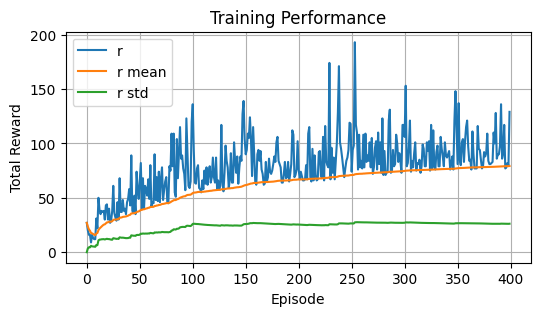

In [4]:
mean_reward = []
std_reward = []
for index in range(len(rewards_per_episode)):
    mean_reward.append(np.mean(rewards_per_episode[:index+1]))
for index in range(len(rewards_per_episode)):
    std_reward.append(np.std(rewards_per_episode[:index+1]))
plt.figure(figsize=(6,3))
plt.plot(rewards_per_episode, label='r')
plt.plot(mean_reward, label='r mean')
plt.plot(std_reward, label='r std')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Performance")
plt.grid()
plt.legend()
plt.show()

#### Test the trained policy

In [32]:
env_view = gym.make("CartPole-v1", render_mode="human")  # Enable rendering
state = discretize_state(env_view.reset()[0])  # Reset the new environment and get initial state
done = False
ts = time.time()
while not done:
    action = np.argmax(Q_mean[state])  # Always exploit
    next_state, _, done, _, _ = env_view.step(action)  # Take the action
    state = discretize_state(next_state)  # Update the state
te = time.time()
print(f'stay alive for {te-ts} seconds')
input()
env_view.close()

stay alive for 0.4808845520019531 seconds


#### Base line

In [ ]:
env_view = gym.make("CartPole-v1", render_mode="human") 
state = discretize_state(env_view.reset()[0])
donee = False
ts = time.time()
i = 0
# for i in range(200):
while not donee:
    # next_state, _, donee, _, _ = env_view.step(int((i%4)/2))
    next_state, _, donee, _, _ = env_view.step(i%2)
    i += 1
te = time.time()
print(f'stay alive for {te-ts} seconds')
input()
env_view.close()

stay alive for 0.4817206859588623 seconds


#### Deep Q-Learning (DQN)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:39<00:00, 12.65it/s]


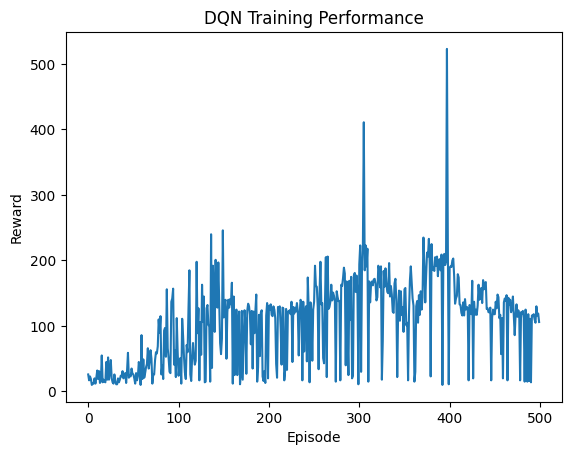

In [12]:
import gymnasium as gym
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Neural Network for Q-Learning
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (np.array(states), np.array(actions), np.array(rewards),
                np.array(next_states), np.array(dones))

    def size(self):
        return len(self.buffer)

# DQN Agent
class DQNAgent:
    def __init__(self, state_size, action_size, gamma=0.99, lr=1e-3,
                 buffer_size=10000, batch_size=64, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.lr = lr
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size

        self.q_network = QNetwork(state_size, action_size)
        self.target_network = QNetwork(state_size, action_size)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.memory = ReplayBuffer(buffer_size)

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_size - 1)
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.q_network(state_tensor)
        return torch.argmax(q_values).item()

    def train(self):
        if self.memory.size() < self.batch_size:
            return
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        # Convert to PyTorch tensors
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        # Compute Q targets
        with torch.no_grad():
            max_next_q = self.target_network(next_states).max(1)[0]
            q_targets = rewards + (1 - dones) * self.gamma * max_next_q

        # Compute current Q values
        current_q = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze()

        # Loss and optimization
        loss = nn.MSELoss()(current_q, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

# Main Training Loop
env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

agent = DQNAgent(state_size, action_size)
episodes = 500
target_update_freq = 10
rewards_per_episode = []

for episode in tqdm(range(episodes)):
    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _, _ = env.step(action)

        agent.memory.add(state, action, reward, next_state, done)
        agent.train()
        state = next_state
        total_reward += reward

    rewards_per_episode.append(total_reward)
    agent.epsilon = max(agent.epsilon * agent.epsilon_decay, agent.epsilon_min)

    if episode % target_update_freq == 0:
        agent.update_target_network()

    # print(f"Episode {episode+1}/{episodes}, Reward: {total_reward}, Epsilon: {agent.epsilon:.3f}")

# Plot Rewards
import matplotlib.pyplot as plt
plt.plot(rewards_per_episode)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("DQN Training Performance")
plt.show()

In [13]:
done = False
env = gym.make("CartPole-v1", render_mode="human")  # Enable rendering
state, _ = env.reset()
while not done:
    action = agent.select_action(state)
    state, _, done, _, _ = env.step(action)
input()
env.close()